# Marginal likelihood

Author: [Zeel B Patel](https://patel-zeel.github.io/), [Nipun Batra](https://nipunbatra.github.io/)

In [3]:
# !pip install pyDOE2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import scipy.stats
from scipy.integrate import simps
import pyDOE2

rc('font', size=16)
rc('text', usetex=True)

From MML book

Definition 6.3 (Expected Value). The expected value of a function $g: \mathbb{R} \rightarrow$ $\mathbb{R}$ of a univariate continuous random variable $X \sim p(x)$ is given by

$$
\mathbb{E}_{X}[g(x)]=\int_{\mathcal{X}} g(x) p(x) \mathrm{d} x
$$

Correspondingly, the expected value of a function $g$ of a discrete random variable $X \sim p(x)$ is given by

$$
\mathbb{E}_{X}[g(x)]=\sum_{x \in \mathcal{X}} g(x) p(x)
$$

From Nando De Freitas https://www.youtube.com/watch?v=mz3j59aJBZQ&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=16&t=1957s
    
starting 50 mins

$I = \int_{\mathcal{X}} g(x)p(x)dx = \dfrac{\sum_{i=1}^N g(x_i)}{N}$ where $x_i \sim p(x)$ is a sample from p(x)

Example

$X \sim \mathcal{N}(0, 1)$

$g(x) = x$

$\mathbb{E}_{X}[g(x)] = \mu = 0$

Case II

$g(x) = x^2$


Now, we know that

$\mathbb{V}_{X}[x]=\mathbb{E}_{X}\left[x^{2}\right]-\left(\mathbb{E}_{X}[x]\right)^{2}$

In [2]:
N = 1000000
np.random.seed(0)
samples = np.random.normal(loc=0, scale=1, size=N)

mu_hat = np.mean(samples)
print(mu_hat)


exp_x2 = np.mean(np.square(samples))
print(exp_x2)

var = np.var(samples)
print(var)

0.0015121465155362318
0.9998449448099948
0.9998426582229105


We can similarly approximate the marginal likelihood as follows:

Marginal likelihood = $\int_{\mathcal{\theta}} P(D|\theta) P(\theta)d\theta = I = \dfrac{\sum_{i=1}^N P(D|\theta_i)}{N}$ where $\theta_i$ is drawn from $p(\theta)$

To do:
    
Linear regression in say two variables. Prior is $p(\theta)\sim \mathcal{N}([0, 0]^T, I)$. We can easily draw samples from this prior then the obtained sample can be used to calculate the likelihood. The marginal likelihood is the empirical mean of likelihoods derived in this way.

### Generating pseudo-random data

x = (100, 1), y = (100, 1)


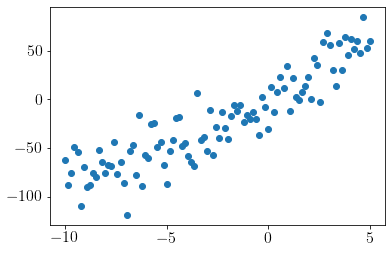

In [3]:
np.random.seed(0)
N = 100 # Number of samples
sigma_n = 20 # Noise std in data
sigma = 100 # Prior std on theta
theta_real = np.array([2,10]).reshape(-1,1)
N_theta = len(theta_real)
x = np.linspace(-10,5,N).reshape(-1,1)
x_with_bias = np.hstack([np.ones((N, 1)), x])
y = np.random.multivariate_normal((x_with_bias@theta_real).reshape(-1), np.eye(N)*sigma_n**2).reshape(-1,1)
plt.scatter(x,y);
print(f'x = {x.shape}, y = {y.shape}')

In [4]:
# Likelihood function
noise_cov = np.eye(N)*sigma_n**2
def LinRegLikelihood(theta0, theta1): # Direct pdf
    return scipy.stats.multivariate_normal.pdf(y.squeeze(), (x_with_bias@np.array([theta0, theta1]).reshape(-1,1)).reshape(-1), noise_cov)

In [5]:
# Calculations
vec_func = np.vectorize(LinRegLikelihood)
np.random.seed(0)
Prior_thetas = np.random.multivariate_normal([0,0], np.eye(N_theta)*sigma**2, size=10000)
Likelihoods = vec_func(Prior_thetas[:,0], Prior_thetas[:,1])
MarginalLikelihood = np.mean(Likelihoods, axis=0).reshape(-1,1)
print('Prior_thetas', Prior_thetas.shape)
print('Likelihoods', Likelihoods.shape)
print('MarginalLikelihood', MarginalLikelihood.shape, 'value =',MarginalLikelihood)

Prior_thetas (10000, 2)
Likelihoods (10000,)
MarginalLikelihood (1, 1) value = [[1.04859619e-196]]


In [6]:
Exact_LL = np.log(scipy.stats.multivariate_normal.pdf(y.squeeze(), np.zeros(N), (x_with_bias@x_with_bias.T)*sigma**2 + np.eye(N)*sigma_n**2))

In [7]:
print('Approx LogLikelihood =', np.log(MarginalLikelihood))
print('Exact LogLikelihood =', Exact_LL)

Approx LogLikelihood = [[-451.25922591]]
Exact LogLikelihood = -451.18739650293173


We have approximated Log likelihood closely.

### Trying empirical bayesian inference

We have marginal likelihood now. Let us try to approximate posterior pdf based on prior pdf.

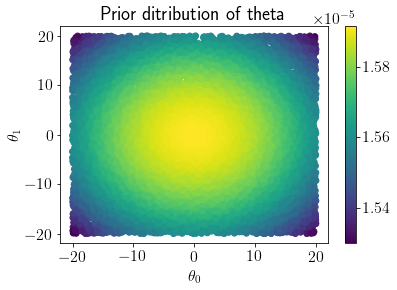

In [8]:
LHS_thetas = pyDOE2.doe_lhs.lhs(n=2,samples=10000)*40 - 20
Likelihoods = np.array([LinRegLikelihood(theta[0], theta[1]) for theta in LHS_thetas]).reshape(-1,1)
Prior_pdf = scipy.stats.multivariate_normal.pdf(LHS_thetas, [0,0], np.eye(2)*sigma**2).reshape(-1,1)
mp = plt.scatter(LHS_thetas[:,0], LHS_thetas[:,1], c=Prior_pdf)
plt.colorbar(mp);
plt.xlabel('$\\theta_0$');plt.ylabel('$\\theta_1$');
plt.title('Prior ditribution of theta');

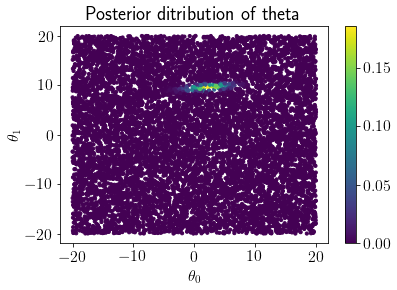

In [9]:
Posterior_pdf = (Likelihoods*Prior_pdf)/MarginalLikelihood
mp = plt.scatter(LHS_thetas[:,0], LHS_thetas[:,1], c=Posterior_pdf, s=10)
plt.colorbar(mp);
plt.xlabel('$\\theta_0$');plt.ylabel('$\\theta_1$');
plt.title('Posterior ditribution of theta');

### Drawing samples from posterior

In [10]:
Posterior_idx = np.random.choice(len(Posterior_pdf), size=1000, p=Posterior_pdf.ravel()/Posterior_pdf.sum())
Posterior_thetas = LHS_thetas[Posterior_idx]

In [11]:
## Posterior mean and covariance
Posterior_thetas.mean(axis=0), np.cov(Posterior_thetas.T)

(array([2.16952649, 9.61024467]),
 array([[5.29858899, 0.60689322],
        [0.60689322, 0.19894884]]))

### Comparing with exact inference

In [12]:
S0 = np.eye(2)*sigma**2
M0 = np.array([0,0]).reshape(-1,1)

Sn = np.linalg.inv(np.linalg.inv(S0) + (x_with_bias.T@x_with_bias)/sigma_n**2)
Mn = Sn@(np.linalg.inv(S0)@M0 + (x_with_bias.T@y)/sigma_n**2)
Mn, Sn

(array([[2.2033994 ],
        [9.60324818]]),
 array([[5.30408854, 0.52248407],
        [0.52248407, 0.20907722]]))

We can see that approximated inference distribution closely matches with exact inference distribution.